In [1]:
import numpy as np     
import pandas as pd
import matplotlib                          
import matplotlib.pyplot as plt
from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
import pandas as pd
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
#clipping loss of 1ppm
katHG33 = pykat.finesse.kat()
katHG33.verbose=False
katHG33.parse("""
l laser 1 0 0 n0
s s0 1 n0 nmod1

mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1

m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 3.8 n3 n4

#higher order mode TEM33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0

#Gaussian model
#Rc=2013.35 so that the loss is 1ppm
cav cavity ITM n2 ETM n3
attr ITM Rc -2679.93
attr ETM Rc 2679.93
#Rc=2679.93 when clipping loss is 1ppm for HG33

pd1 pdh 60M 0 n1

set err pdh re
lock clock $err 1 1n
put* ETM phi $clock


maxtem 8

""")

In [3]:
#clipping loss of 1ppm
katLG22 = pykat.finesse.kat()
katLG22.verbose=False
katLG22.parse("""

l laser 1 0 0 n0
#gauss g1 laser n0 1m 0
maxtem 8

s s0 1 n0 nmod1
mod eom 60M 0.3 1 pm nmod1 nmod2
s s1 0 nmod2 n1
m1 ITM 0.014 3.75e-05 0 n1 n2
s sCav 3994.4692 n2 n3
m1 ETM 5e-06 3.75e-05 26.5 n3 n4

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180

#Gaussian model
cav cavity ITM n2 ETM n3
attr ITM Rc -2789.58
attr ETM Rc 2789.58
#Rc=2789.58 when clipping loss is 1ppm for LG22

pd1 pdh 60M 0 n1
set err pdh re
lock clock $err 1 1n
put* ETM phi $clock

""")

In [4]:
# the power seems to go up when applying a map
# so I should use zero map as the reference when calculating loss instead of no map

LG22nomap = katLG22.deepcopy()
LG22nomap.parse("""
        pd Pcirc n3
        """)
LG22nomap.noxaxis = True
outLGnomap=LG22nomap.run()
powernomap=outLGnomap["Pcirc"]

LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]

LG22map = katLG22.deepcopy()
LG22map.parse("""
        map ETM Z66order1phasemap.txt
        pd Pcirc n3
        """)
LG22map.noxaxis = True
outLGmap=LG22map.run()
powermap=outLGmap["Pcirc"]

print(f" The circulating Power with map is {powermap} \n The circulating Power with zero map is {powerzeromap} \n \
The circulating Power without map is {powernomap}")

 The circulating Power with map is 269.362269781898 
 The circulating Power with zero map is 269.514016825473 
 The circulating Power without map is 268.086866624925


In [5]:
# to create a prefect LG22 basis to be projected into
LG22nomap = katLG22.deepcopy()  
LG22nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outLGnomap=LG22nomap.run()
beamLGnomap=outLGnomap["ccd"]


#reference power when applying zero map
LG22zeromap = katLG22.deepcopy()
LG22zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
LG22zeromap.noxaxis = True
outLGzeromap=LG22zeromap.run()
powerzeromap=outLGzeromap["Pcirc"]


pkLG=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        LG22beam = katLG22.deepcopy()
        LG22beam.parse(f"""
                map ETM Z{n}{m}order1phasemap.txt
                beam ccd 0 n3
                xaxis ccd x lin -7 7 200
                x2axis ccd y lin -7 7 200
                yaxis abs:deg
                pd Pcirc n3
                """)
        pkLG.run(LG22beam)
outLGmap = pkLG.getResults()


# projecting the measureed beam profile to LG22 basis to get the purity
# and use the purity and measured power to get the loss
LGpurity=[]
LGloss=[]
for i in range(28):
    beamLGmap=outLGmap[i]['ccd']
    powermap=outLGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamLGmap)*beamLGnomap)*np.sum(np.conj(beamLGnomap)*beamLGmap))
    b=np.sum(np.abs(beamLGmap)**2)
    c=np.sum(np.abs(beamLGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    LGpurity.append(purity)
    LGloss.append(loss)
    
pd.Series(LGpurity).to_pickle('pkl/LG22purity.pkl')
pd.Series(LGloss).to_pickle('pkl/LG22loss.pkl')

/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2114: UserWarning: 'KatRun2D' does not have attribute called 'katPath'
  r.katPath = kat_exec
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2345: UserWarning: 'KatRun2D' does not have attribute called 'save_output'
  r.save_output = save_output
/opt/anaconda3/lib/python3.7/site-packages/pykat/finesse.py:2362: UserWarning: 'KatRun2D' does not have attribute called 'save_input'
  r.save_input = save_kat
/opt/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for [Liu]: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)
Parallel jobs: 100%|##########################################################|

In [6]:
# to create a prefect HG33 basis to be projected into
HG33nomap = katHG33.deepcopy() 
HG33nomap.parse("""
        beam ccd 0 n3
        xaxis ccd x lin -7 7 200
        x2axis ccd y lin -7 7 200
        yaxis abs:deg
        """)
outHGnomap=HG33nomap.run()
beamHGnomap=outHGnomap["ccd"]


#reference power when applying zero map
HG33zeromap = katHG33.deepcopy()
HG33zeromap.parse("""
        map ETM Z2-2order0phasemap.txt
        pd Pcirc n3
        """)
HG33zeromap.noxaxis = True
outHGzeromap=HG33zeromap.run()
powerzeromap=outHGzeromap["Pcirc"]


pkHG=parakat()
for n in range(7):
    for m in range(-n,n+1,2):
        HG33beam = katHG33.deepcopy()
        HG33beam.parse(f"""
                map ETM Z{n}{m}order1phasemap.txt
                beam ccd 0 n3
                xaxis ccd x lin -7 7 200
                x2axis ccd y lin -7 7 200
                yaxis abs:deg
                pd Pcirc n3
                """)
        pkHG.run(HG33beam)
outHGmap = pkHG.getResults()

HGpurity=[]
HGloss=[]
for i in range(28):
    beamHGmap=outHGmap[i]['ccd']
    powermap=outHGmap[i]["Pcirc"]
    a=np.real(np.sum(np.conj(beamHGmap)*beamHGnomap)*np.sum(np.conj(beamHGnomap)*beamHGmap))
    b=np.sum(np.abs(beamHGmap)**2)
    c=np.sum(np.abs(beamHGnomap)**2)
    purity=np.sqrt(a/(b*c))
    
    loss=1-np.real(powermap*purity**2/powerzeromap)[0][0]
    HGpurity.append(purity)
    HGloss.append(loss)
    
pd.Series(HGpurity).to_pickle('pkl/HG33purity.pkl')
pd.Series(HGloss).to_pickle('pkl/HG33loss.pkl')

Parallel jobs: 100%|##########################################################|

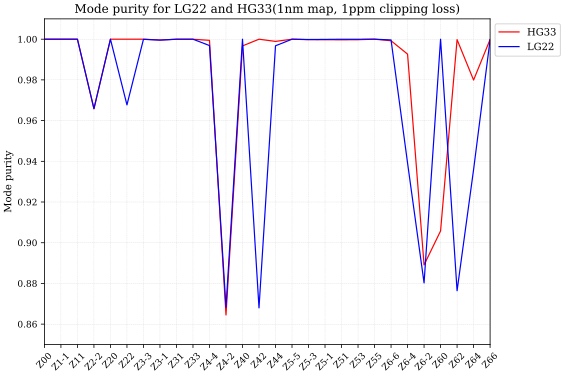

In [7]:
HG33purityZnm_array=pd.read_pickle('pkl/HG33purity.pkl').values
LG22purityZnm_array=pd.read_pickle('pkl/LG22purity.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33purityZnm_array,'r',label='HG33')
ax.plot(LG22purityZnm_array,'b',label='LG22')
ax.set_ylabel("Mode purity")
ax.set_title("Mode purity for LG22 and HG33(1nm map, 1ppm clipping loss)")
ax.set_ylim(0.85,1.01)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()

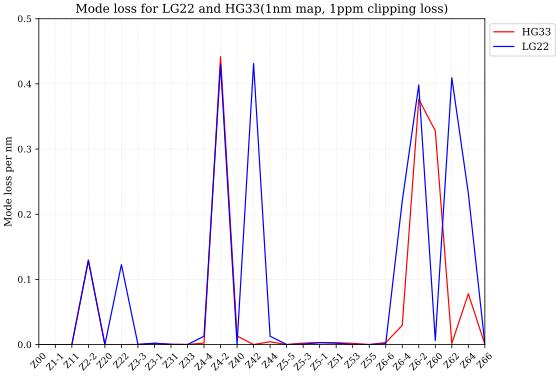

In [8]:
LG22lossZnm_array=pd.read_pickle('pkl/LG22loss.pkl').values
HG33lossZnm_array=pd.read_pickle('pkl/HG33loss.pkl').values

xticks=['Z00','Z1-1','Z11','Z2-2','Z20','Z22','Z3-3','Z3-1','Z31','Z33','Z4-4','Z4-2','Z40','Z42','Z44','Z5-5','Z5-3','Z5-1','Z51','Z53','Z55','Z6-6','Z6-4','Z6-2','Z60','Z62','Z64','Z66']
fig,ax =plt.subplots(figsize=(8,6))
ax.plot(HG33lossZnm_array,'r',label='HG33')
ax.plot(LG22lossZnm_array,'b',label='LG22')
ax.set_ylabel("Mode loss per nm")
ax.set_title("Mode loss for LG22 and HG33(1nm map, 1ppm clipping loss)")
ax.set_ylim(0,0.5)
ax.set_xticks(range(28))
ax.set_xticklabels(xticks,rotation=45, fontsize=9)
ax.legend(loc=2,bbox_to_anchor=(1,1))
plt.show()